In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation, Flatten
import tensorflow_model_optimization as tfmot

In [2]:
with np.load('mnist.npz') as f:
    x_train, y_train = f['x_train'], f['y_train']

x_train = x_train/255 # Normalize pixel values to [0,1] and flatten each image to 1D.
y_train = keras.utils.to_categorical(y_train) # One-hot encoding

print('This is how a one-hot encoded 5 looks like')
print(y_train[0])

This is how a one-hot encoded 5 looks like
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [3]:
def create_base_model():
    raw_model = Sequential()
    raw_model.add(Conv2D(input_shape=(28, 28, 1), kernel_size=(16, 16), filters=32, strides=(4, 4), activation='relu'))
    raw_model.add(Conv2D(kernel_size=(3, 3), filters=64, strides=(1, 1), activation='relu'))
    raw_model.add(Flatten())
    raw_model.add(Dense(10, activation='softmax'))
    return raw_model

In [4]:
model = create_base_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 4, 4, 32)          8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
Total params: 29,290
Trainable params: 29,290
Non-trainable params: 0
_________________________________________________________________


2021-12-26 22:07:10.058165: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2021-12-26 22:07:13.653894: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/5
118/118 [==============================] - 2s 15ms/step - loss: 0.9753 - accuracy: 0.7112
Epoch 2/5
118/118 [==============================] - 2s 14ms/step - loss: 0.2856 - accuracy: 0.9159
Epoch 3/5
118/118 [==============================] - 2s 14ms/step - loss: 0.1799 - accuracy: 0.9477
Epoch 4/5
118/118 [==============================] - 2s 18ms/step - loss: 0.1354 - accuracy: 0.9600
Epoch 5/5
118/118 [==============================] - 2s 16ms/step - loss: 0.1026 - accuracy: 0.9695


Text(0, 0.5, 'Accuracy')

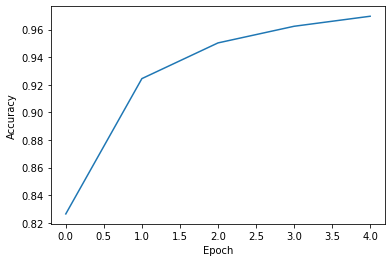

In [5]:
# Fit the model:
model.compile(optimizer='RMSprop',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
history = model.fit(x_train.reshape(-1,28,28,1), y_train, batch_size=512, epochs=5)
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Model prediction: 9


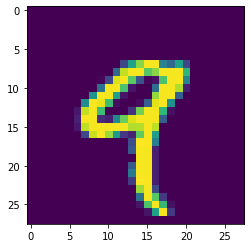

In [6]:
# classify image:
k = 4
image = x_train[k]
y_predict = np.argmax(model.predict(image[None, :,:, None]))

print("Model prediction:", y_predict)
plt.imshow(image.reshape(28, 28))

# Save the model

In [7]:
model.save("mnist.h5")

# Prune the model

In [32]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 512
epochs = 5
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = x_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

print("end_step:", end_step)

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.5,
                                                               final_sparsity=0.15,
                                                               begin_step=0,
                                                               end_step=end_step)
}

raw_model = create_base_model()
#raw_model.load_weights(pretrained_weights)

model_pruned = prune_low_magnitude(raw_model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_pruned.compile(loss='categorical_crossentropy', metrics=['accuracy'])

#model_for_pruning.summary()

end_step: 530


/Users/thomas/opt/miniconda3/envs/test/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [33]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  #tfmot.sparsity.keras.PruningSummaries(log_dir="log")
]

model_pruned.fit(x_train.reshape(-1,28,28,1), y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)


#%tensorboard --logdir={"log"}

Epoch 1/5
106/106 [==============================] - 2s 16ms/step - loss: 1.0180 - accuracy: 0.7107 - val_loss: 0.2896 - val_accuracy: 0.9168
Epoch 2/5
106/106 [==============================] - 2s 15ms/step - loss: 0.3046 - accuracy: 0.9123 - val_loss: 0.2134 - val_accuracy: 0.9408
Epoch 3/5
106/106 [==============================] - 2s 16ms/step - loss: 0.2317 - accuracy: 0.9337 - val_loss: 0.1966 - val_accuracy: 0.9463
Epoch 4/5
106/106 [==============================] - 2s 16ms/step - loss: 0.1755 - accuracy: 0.9499 - val_loss: 0.1288 - val_accuracy: 0.9643
Epoch 5/5
106/106 [==============================] - 2s 15ms/step - loss: 0.1387 - accuracy: 0.9588 - val_loss: 0.1036 - val_accuracy: 0.9702


In [34]:
model_pruned_export = tfmot.sparsity.keras.strip_pruning(model_pruned)

In [35]:
total_weights = 0
total_weights_0 = 0

for idx, layer in enumerate(model_pruned.layers):
    weights_layer = 0
    weights_0 = 0
    
    if len(layer.weights) == 0:
        continue

    for weight in np.nditer(layer.weights):
        if type(weight) != tuple:
            continue

        weights_layer += 1
        if weight[0] == 0:
            weights_0 += 1

    print("Layer: ", idx, "Zero weights:", weights_0, "/", weights_layer)
    total_weights += weights_layer
    total_weights_0 += weights_0

print("Total 0-weights:", total_weights_0, "/", total_weights, " => ", (total_weights_0 / total_weights) * 100, "%")

Layer:  0 Zero weights: 1229 / 8192
Layer:  1 Zero weights: 2766 / 18432
Layer:  2 Zero weights: 0 / 0
Layer:  3 Zero weights: 384 / 2560
Total 0-weights: 4379 / 29184  =>  15.004797149122806 %


# Quantize the model

In [36]:
def representative_dataset_gen():
  for i in range(100):
    yield [x_train[i].reshape(-1,28,28,1).astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model_pruned_export)
#converter = tf.lite.TFLiteConverter.from_keras_model(model)

# NOTE: The current version of TensorFlow appears to break the model when using optimizations
#    You can try uncommenting the following if you would like to generate a smaller size .tflite model
#converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/vb/mchghtt9519g6bs7gqw029vm0000gn/T/tmpv2ubhu50/assets


INFO:tensorflow:Assets written to: /var/folders/vb/mchghtt9519g6bs7gqw029vm0000gn/T/tmpv2ubhu50/assets
2021-12-26 22:22:44.557791: I tensorflow/core/grappler/devices.cc:78] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2021-12-26 22:22:44.557970: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2021-12-26 22:22:44.558964: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:928] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.001ms.
  function_optimizer: function_optimizer did nothing. time = 0ms.

2021-12-26 22:22:44.745680: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:316] Ignored output_format.
2021-12-26 22:22:44.745698: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:319] Ignored drop_control_dependency.


36000

# Test the tflite model

In [37]:
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_quantization_parameters = input_details[0]['quantization_parameters']
output_quantization_parameters = output_details[0]['quantization_parameters']

print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])
print("quantization scale:", input_quantization_parameters['scales'])
print("quantization zero point:", input_quantization_parameters['zero_points'])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])
print("quantization scale:", output_quantization_parameters['scales'])
print("quantization zero point:", output_quantization_parameters['zero_points'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])
print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])

== Input details ==
name: conv2d_6_input
shape: [ 1 28 28  1]
type: <class 'numpy.float32'>
quantization scale: []
quantization zero point: []

== Output details ==
name: Identity
shape: [ 1 10]
type: <class 'numpy.float32'>
quantization scale: []
quantization zero point: []

DUMP INPUT
{'name': 'conv2d_6_input', 'index': 13, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

DUMP OUTPUT
{'name': 'Identity', 'index': 14, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

### Accuracy

In [38]:
def predict(interpreter, input_data):
    interpreter.set_tensor(input_details[0]["index"], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]["index"])
    return output_data


def measure_accuracy(interpreter, samples = len(x_train)):
    output_data = []

    for idx, sample in enumerate(x_train[:samples]):
        input_data = np.array(sample, dtype=np.float32)
        input_data = np.expand_dims(input_data, axis=0)
        input_data = np.expand_dims(input_data, axis=3)
        output_data.append(predict(interpreter, input_data))

    a = [np.argmax(y, axis=None, out=None) for y in output_data]
    b = [np.argmax(y, axis=None, out=None) for y in y_train[:samples]]

    accuracy = (np.array(a) == np.array(b)).mean()
    print("TFLite Accuracy:", accuracy)

In [39]:
measure_accuracy(interpreter, 1000)

TFLite Accuracy: 0.964


# Save .TFLite as C Array

In [40]:
import binascii

def convert_to_c_array(bytes) -> str:
  hexstr = binascii.hexlify(bytes).decode("UTF-8")
  hexstr = hexstr.upper()
  array = ["0x" + hexstr[i:i + 2] for i in range(0, len(hexstr), 2)]
  array = [array[i:i+10] for i in range(0, len(array), 10)]
  return ",\n  ".join([", ".join(e) for e in array])

tflite_binary = open("model.tflite", 'rb').read()
ascii_bytes = convert_to_c_array(tflite_binary)
c_file = "alignas(8) const unsigned char g_model[] = {\n  " + ascii_bytes + "\n};\nconst unsigned int g_model_len = " + str(len(tflite_binary)) + ";"
open("model.h", "w").write(c_file)

223286

# Convert test data to C array

In [11]:
k = 0
test_data = x_train[k]

print("Shape:", test_data.shape)

# float test_data[28][28] = {{0, 1, 2}, {0, 2, 3}};

def convert_to_float_c_array(data):
    res = "float test_data[28][28] = "
    rows = []
    for i, row in enumerate(data):
        string_row = [str(d) for d in row]
        rows.append(("{" + (", ".join(string_row)) + "}"))

    
    array_content = ("{" + (", ".join(rows)) + "}")
    res += array_content
    res += ";"
    return res

    
        


#convert_to_float_c_array([[1,2,3],[4,5,6],[7,8,9]])
convert_to_float_c_array(test_data)



Shape: (28, 28)


'float test_data[28][28] = {{0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0}, {0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0}, {0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0}, {0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0}, {0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0}, {0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011764705882352941, 0.07058823529411765, 0.07058823529411765, 0.07058823529411765, 0.49411764705882355, 0.5333333333333333, 0.6862745098039216, 0.10196078431372549, 0.6509803921568628, 1.0, 0.9686274